# First: load imports needed for the project and preparation of the project

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

fatal: destination path 'Bsc_Thesis' already exists and is not an empty directory.
/content/Bsc_Thesis
/content


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.12
Pandas: 1.3.5
Numpy: 1.21.5
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

# Set to True to print the graphs
print_graphs = False

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Dataset normalisation

We divide every valu by the max value of this specific feature to have a value between 0 and 1

In [6]:
# apply the maximum absolute scaling in Pandas using the .abs() and .max() methods
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
      if column != 'time':
        df_scaled[column] = df_scaled[column]  / float(df_scaled[column].max())
    return df_scaled
    
# call the maximum_absolute_scaling function
dataset_norm = maximum_absolute_scaling(dataset_clean)

dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,0.043767,0.030937,0.033277,0.952282,0.951250,0.946197,0.8091,0.6864,0.4875,0.997496,0.363636,0.511236,0.714286,0.829787,0.800000,0.518072,0.476744,0.636364
1,2020-06-01 00:01:00,0.043921,0.030918,0.033863,0.951881,0.951154,0.946058,0.8080,0.6903,0.4904,0.997201,0.454545,0.359551,0.500000,0.574468,0.555556,0.361446,0.319767,0.181818
2,2020-06-01 00:02:00,0.043762,0.044269,0.033418,0.951268,0.951066,0.946017,0.8113,0.9274,0.4806,0.997207,0.363636,0.359551,0.500000,0.574468,0.555556,0.361446,0.319767,0.181818
3,2020-06-01 00:03:00,0.044183,0.044156,0.033586,0.952565,0.951819,0.946821,0.8249,0.9123,0.4778,0.997342,0.454545,0.370787,0.571429,0.595745,0.555556,0.367470,0.331395,0.181818
4,2020-06-01 00:04:00,0.043808,0.044186,0.033540,0.951928,0.951527,0.946301,0.8081,0.9291,0.4552,0.997354,0.363636,0.477528,0.785714,0.957447,0.911111,0.451807,0.395349,0.545455


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals

In [7]:
if print_graphs is True:

    # PLN_1 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 1, 'PLN_1')

    # PLN_1 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 1, 'PLN_1')

    # PLN_2 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 2, 'PLN_2')

    # PLN_2 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 2, 'PLN_2')

    # PLN_3 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 3, 'PLN_3')

    # PLN_3 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 3, 'PLN_3')

    # ULL1 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 4, 'ULL1')

    # ULL1 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 4, 'ULL1')

    # ULL2 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 5, 'ULL2')

    # ULL2 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 5, 'ULL2')

    # ULL3 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 6, 'ULL3')

    # ULL3 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 6, 'ULL3')

    # COS_PHI1 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 7, 'COS_PHI1')

    # COS_PHI1 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 7, 'COS_PHI1')

    # COS_PHI2 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 8, 'COS_PHI2')

    # COS_PHI2 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 8, 'COS_PHI2')

    # COS_PHI3 in a weekly interval

    utils_bsc.week_plot(dataset_clean, 9, 'COS_PHI3')

    # COS_PHI3 in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 9, 'COS_PHI3')

    # FREQ in a weekly interval

    utils_bsc.week_plot(dataset_clean, 10, 'FREQ')

    # FREQ in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 10, 'FREQ')

    # RC_DC in a weekly interval

    utils_bsc.week_plot(dataset_clean, 11, 'RC_DC')

    # RC_DC in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 11, 'RC_DC')

    # RC_AC in a weekly interval

    utils_bsc.week_plot(dataset_clean, 12, 'RC_AC')

    # RC_AC in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 12, 'RC_AC')

    # RC_50Hz in a weekly interval

    utils_bsc.week_plot(dataset_clean, 13, 'RC_50Hz')

    # RC_50Hz in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 13, 'RC_50Hz')

    # RC_150Hz in a weekly interval

    utils_bsc.week_plot(dataset_clean, 14, 'RC_150Hz')

    # RC_150Hz in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 14, 'RC_150Hz')

    # RC_100Hz_1kHz in a weekly interval

    utils_bsc.week_plot(dataset_clean, 15, 'RC_100Hz_1kHz')

    # RC_100Hz_1kHz in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 15, 'RC_100Hz_1kHz')

    # RC_100Hz_1kHz in a weekly interval

    utils_bsc.week_plot(dataset_clean, 16, 'RC_100Hz_1kHz')

    # RC_100Hz_1kHz in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 16, 'RC_100Hz_1kHz')

    # RC_more_1kHz in a weekly interval

    utils_bsc.week_plot(dataset_clean, 17, 'RC_more_1kHz')

    # RC_more_1kHz in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 17, 'RC_more_1kHz')

    # RC_more_10kHz in a weekly interval

    utils_bsc.week_plot(dataset_clean, 18, 'RC_more_10kHz')

    # RC_more_10kHz in a daily interval (only the values of weekdays between 4:00 and 19:30)

    utils_bsc.daily_plot(dataset_clean, 18, 'RC_more_10kHz')

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval otside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [8]:
# Create 27840 batches of longitud 60

endset = utils_bsc.create_batches(dataset=dataset_norm, batch_size=60, device=device)
    
print(f'{len(endset)} sequences of longitud {endset[0].shape[0]} with {endset[0].shape[1]} features')

# Spliting into train and test sets

training_data, testing_data = train_test_split(endset, test_size=0.1, random_state=25)

train_set = torch.stack(training_data).float().to(device)
test_set = torch.stack(testing_data).float().to(device)

print(f'length of training set: {train_set.shape[0]}')
print(f'length of test set: {test_set.shape[0]}')

27840 sequences of longitud 60 with 18 features
length of training set: 25056
length of test set: 2784


# Create a Baseline Model

I am taking the median of all features to create an statistical baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [16]:
data_median = []
data_mean = []

print('Calculate Median and Mean of all 18 features')

for i in tqdm(range(1, dataset_norm.shape[1])):
  sum = []
  for j in range(1, dataset_norm.shape[0]):
    sum.append(dataset_norm.iloc[j][i])
  
  data_median.append(torch.median(torch.FloatTensor(sum)).to(device))
  data_mean.append(torch.mean(torch.FloatTensor(sum)).to(device))

data_median = torch.FloatTensor(data_median).to(device)
data_mean = torch.FloatTensor(data_mean).to(device)

print('')
print(data_median)
print(data_mean)


Calculate Median and Mean of all 18 features


100%|██████████| 18/18 [01:51<00:00,  6.22s/it]


tensor([0.1677, 0.2683, 0.2281, 0.9528, 0.9534, 0.9536, 0.9874, 0.9854, 0.9610,
        0.9976, 0.4545, 0.4494, 0.5714, 0.6809, 0.6222, 0.4518, 0.3953, 0.2727],
       device='cuda:0')
tensor([0.2756, 0.2766, 0.2813, 0.9516, 0.9523, 0.9524, 0.9404, 0.9095, 0.8107,
        0.9976, 0.4133, 0.4465, 0.5987, 0.6876, 0.6424, 0.4463, 0.3998, 0.3429],
       device='cuda:0')


In [15]:
for i in tqdm(range(len(train_set))):
      batch = train_set[i]

100%|██████████| 25056/25056 [00:00<00:00, 597578.13it/s]


# Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [12]:
def positional_encoding(seq_len: int, dim_model: int, device):
    
    # Tensor with the positions of every sequence element (0 to seq_len)
    pos = torch.arange(seq_len, dtype=float32, device=device).reshape(1, -1, 1)
    
    # Tensor with the positions of every feature in the sequence (0 to dim_model)
    dim = torch.arange(dim_model, dtype=float32, device=device).reshape(1, 1, -1)

    phase = pos / (1e4 ** (torch.div(dim, dim_model, rounding_mode='floor')))

    position_encoding = torch.where(dim.long() % 2 == 0, sin(phase), cos(phase))

    return position_encoding.to(device)


class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, debug: bool = False, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device
        self.debug = debug

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)
        
    def forward (self, src):
        
        mask = self.generate_square_mask(len(src))
        if self.debug is True:
            print('mask creation: ok')

        src_pos = src + positional_encoding(src.shape[1], src.shape[2], self.device)
        if self.debug is True:
            print('Pos encoder (encoder): ok')

        output = self.encoder (src, mask)
        if self.debug is True:
            print('encoder pass: ok')
        
        output = self.decoder (src_pos, output)
        if self.debug is True:
            print('decoder pass: ok')
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [13]:
# Initialize Transformer Model and Optimizer

model = Transformer (num_encoder_layers=3,
                     num_decoder_layers=3,
                     feature_size=18,
                     output_size=18,
                     num_heads=3,
                     device = device,
                     batch_first=False,
                     debug=False)

print('Setup model Ok')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print('Setup optimizer Ok')

# List to keep track of the losses
loss_list = []
# Initialize optimizer gradients
optimizer.zero_grad()

epochs = 1

out = []

for e in range(epochs):
  print('Epoch: ', e + 1)

  for i in tqdm(range(len(train_set))):

      batch = train_set[i].unsqueeze(0)
      net_out = model.forward(batch)
      out.append(net_out)
      loss = torch.mean((net_out - batch) ** 2).to(device)

      loss.backward()
      optimizer.step()

      loss_list.append(loss.item())



Setup model Ok
Setup optimizer Ok
Epoch:  1


100%|██████████| 25056/25056 [07:55<00:00, 52.68it/s]


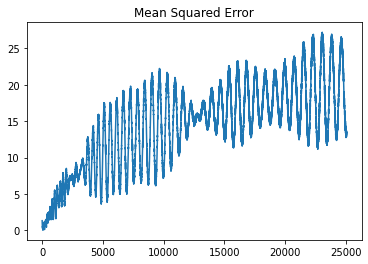

In [17]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

ax.plot(loss_list)
ax.set_title("Mean Squared Error")
fig.canvas.draw()


Ideas, things to remember, to search, etc...

reconstruction, vergelich mit base line model